# Pasos Previos

In [1]:
# Si no está instalado, instalar fastai 2.3.0
# !pip install -q fastai==2.3

In [1]:
import fastai
fastai.__version__

'2.3.0'

In [2]:
#Importar Librerías
 
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 10px !important;}</style>"))
import os
import shutil
import random
import glob
from sympy import *
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools as it
from PIL import Image
from IPython.display import clear_output
import random
if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you change the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir
from fastai.tabular.all import *
from skimage import data
from skimage.filters import threshold_multiotsu
import inspect
from sklearn.manifold import TSNE
from sklearn import decomposition
#from sklearn.preprocessing import scaled
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import more_itertools
from sklearn.manifold import TSNE
import cv2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import imutils
from time import time
init_printing() # Numeros más bonitos

Notebook directory: /home/gabriel/Desktop


In [3]:
# Contenido (carpetas donde se guardan las pcas, etc.):

carp = 'PCAs_5_layers_tests' #Carpeta de donde salen las PCAs
 
dd = top_dir + '/' + carp

if not os.path.isdir(dd):
    print('Creating directory:\n',dd)
    os.mkdir(dd)
 
dir = os.path.join(top_dir,carp)

Modificamos la función SaveModelCallback para quitar el print de "Better model found..." para acelerar el proceso.

In [4]:
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

Función para generar un potencial como DataFrame, con una simetría concreta. Puedes pedirle que te genere {x,y,V, bin} con with_z = False o {x,y,z,V,bin} con with_z = True. Añadir la variable z lo que hace es generar puntos como {0,0,0,V(0,0)}, {0,0,1,V(0,0)}, {0,0,2,V(0,0)} ... {0,1,0,V(0,1)},{0,1,1,V(0,1)}, ... {1,1,0,V(1,1)}, {1,1,1,V(1,1)} ... Como puede verse, la z es irrelevante para el valor de V, es una variable sin información, que está ahí únicamente por añadir información irrelevante.

El valor de 'bin' que se añade al final es el potencial reescalado, usando cuantiles, con la finalidad de mistrar más claramente la simetría.

In [6]:
def potential_df(symmetry = 'None', with_z = False):
  
  # Generar un solo potencial, pero le tienes que decir la simetría que 
  # quieres que tenga. por defecto pondrá sin simetría.

  [x_min,x_max]=  [-1,1]
  [y_min,y_max]= [-1,1]
  [z_min,z_max] = [-1,1]
  x_num = 50 # Number of values given to x
  y_num = 50 # Number of values given to y
  z_num = 50 # Number of values given to y
  # inputs es el resultado de emparejar cada x con todas las y
  # Si x = [0,1,2] e y = [a,b], 
  # input = [[0,a],[0,b],[1,a],[1,b],[2,a],[2,b]]


  max_power = 5
  min_power = 1
  count_powers = max_power-min_power+1

  #Una función que te da un array de: [x,x^2,x^3...] entre min_power y max_power
  def powers(var): 
      powers=[]
      for i in range(min_power,max_power+1,1):
          powers.append(var**i)
      return powers

  def V(x,y):
      if symmetry=='continuous_rotation':
          c_i_s = np.random.normal(0,1, size=( count_powers))
          return np.dot(c_i_s,powers(np.sqrt(x**2+y**2)))
      
      if symmetry=='none':
          c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
          res = np.array([np.dot(np.array(powers(np.array(x[i]))),np.matmul(c_ij_s,powers(y[i]))) for i in range(len(x_s))])
          return res

      if symmetry=='continuous_translation':
          c_i_s = np.random.normal(0,1, size=( count_powers))
          return np.dot(c_i_s,powers(np.random.normal(0,1)*x+np.random.normal(0,1)*y)) 

      if symmetry=='discrete_translation':
          n_s=6
          ni = np.random.choice([-1,1],n_s) * np.random.normal(5,3, n_s)
          return ni[0]*np.sin(ni[1]*(x)+ni[2]*y) +ni[3]*np.cos(ni[4]*x + ni[5]*y)

      if symmetry=='reflection':
          c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
          rn1 = np.random.normal(0,1)
          rn2 = np.random.normal(0,1)
          rn3 = np.random.normal(0,1)
          rn4 = np.random.normal(0,1)
          return np.array([np.dot(powers((rn1*x[i]**2+rn2*y[i]**2)), np.matmul(c_ij_s,powers(rn3*x[i]**2+rn4*y[i]**2))) for i in range(len(x_s))])


  #write a data frame

  if with_z == False:
    inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
    #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
    x_s , y_s = inputs.T #Separamos las parejas

    gg = V(x_s,y_s)

    data = {
          'x':x_s,        
          'y':y_s,
          'V':V(x_s,y_s)
          }

    df = pd.DataFrame(data,columns=['x','y','V'])    

  else:

    # Hay que cambiar un  poco el procedimiento para acelerar el proceso y no 
    # calcular x_num*y_num*z_num valores del potencial sino solo x_num*y_num

    inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
    #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
    x_s , y_s = inputs.T #Separamos las parejas

    V_temp = V(x_s,y_s)

    V_vals = []

    for v in V_temp:
      V_vals.append([v]*z_num)

    V_vals = np.array(V_vals).flatten()

    inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num),np.linspace(z_min,z_max,z_num))))
    #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
    x_s , y_s, z_s = inputs.T #Separamos las parejas


    data = {
          'x':x_s,        
          'y':y_s,
          'z':z_s,
          'V':V_vals
          }

    df = pd.DataFrame(data,columns=['x','y','z','V'])


  # Para evitar divergencias y no dar tanta importancia a puntos donde el potencial es muy alto
  # agrupamos los puntos del potencial en bines. Intentamos que haya un bin por 
  # punto del potencial, pero hay puntos en los que el potencial
  # vale lo mismo. Agrupamos esos puntos en bines.

  n_attempted_bins =  len(x_s)

  binning = pd.qcut(df.V, q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
  df['bin']=binning[0]
  #n_actual_bins=len(binning[1])-1

  # Es importante normalizar los bines, para que se pueda generalizar a cualquier potencial
  df['bin']=df.bin/np.max(df.bin)

  return df

# Columna z Redundante

Estudiar el efecto de la columna de valores z sin información

In [8]:
# Función que genera muchos potenciales de este tipo

def make_potentials(num_pot_cada = 10, with_z = True, symmetries = None):

#--------------------------#

# INPUT
# num_pot_cada : numero potenciales generados para cada tipo de simetria. int
# with_z : si es True, hay una columna z sin información. Si es false, no hay. bool
# symmetries : string or list of strings. Simetrias que quieres generar

# OUTPUT
# potenciales : list of pandas dataframes con los potenciales
# potenciales_tags :  list of strings, nombres de las simetrias de los potenciales

#--------------------------#

  #Posibles simetrias:
  #symmetries = ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']

  if symmetries == None:
    symmetries = ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']

  if type(symmetries) == str:
    symmetries = [symmetries]

  potenciales = []
  potenciales_tags = []

  for symmetry in symmetries:
    funs_temp = []
    for i in range(num_pot_cada):
      pot_temp = potential_df(symmetry = symmetry, with_z= with_z)

      funs_temp.append(pot_temp)

    funs_tags_temp = [symmetry for i in range(num_pot_cada)]
    potenciales = potenciales + funs_temp 
    potenciales_tags = potenciales_tags + funs_tags_temp


  return potenciales, potenciales_tags


## Ejemplo:

In [27]:
a,b = make_potentials(num_pot_cada = 1,with_z=True,symmetries = 'continuous_rotation')
print(b)

['continuous_rotation']


In [28]:
a[0].head()

,x,y,z,V,bin
0,-1.0,-1.0,-1.000000,0.923482,1.0
1,-1.0,-1.0,-0.959184,0.923482,1.0
2,-1.0,-1.0,-0.918367,0.923482,1.0
3,-1.0,-1.0,-0.877551,0.923482,1.0
4,-1.0,-1.0,-0.836735,0.923482,1.0


In [29]:
# ¿Tiene el dataframe una columna llamada z?
hasattr(a[0], 'l'), hasattr(a[0], 'z')

(False, True)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'V'}>],
       [<AxesSubplot:title={'center':'bin'}>, <AxesSubplot:>]],
      dtype=object)

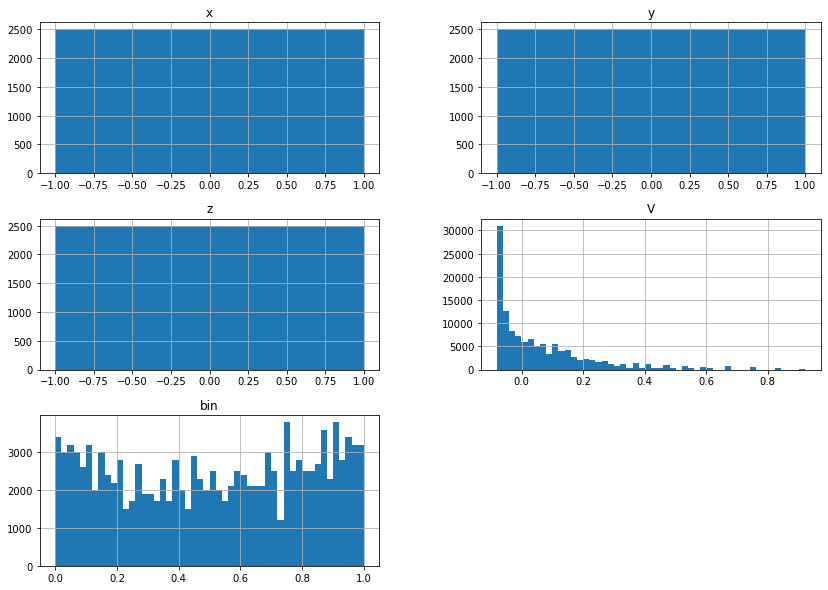

In [30]:
#Mostrar distribución de valores de las columnas del dataframe con el potencial

a[0].hist(figsize = [14,10], bins = 50)

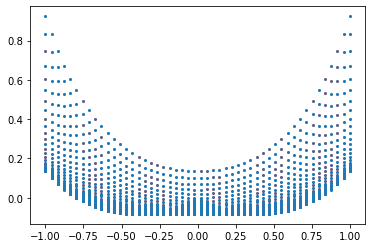

In [31]:
plt.plot(a[0].x,a[0].V, '.', ms = 1)

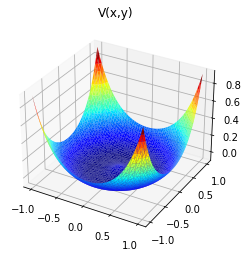

Text(0.5, 0.92, 'bin(x,y)')

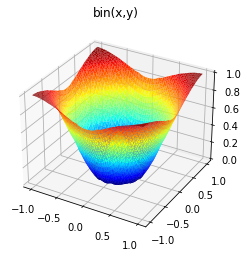

In [34]:
#df = potential_df('reflection')
df = a[0].copy()
ax = plt.axes(projection='3d')
ax.plot_trisurf(df.x, df.y, df.V, linewidth=0.2, cmap = 'jet')
plt.title('V(x,y)')
plt.show()
ax2 = plt.axes(projection='3d')
ax2.plot_trisurf(df.x, df.y, df.bin, linewidth=0.2, cmap = 'jet')
plt.title('bin(x,y)')

## Hacer PCAs

Hacemos ahora una cierta cantidad de potenciales:

In [7]:
syms = ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']
#syms = ['continuous_rotation']
potenciales,tags = make_potentials(num_pot_cada = 1,with_z=True,symmetries = syms)

Entrenar la red y sacar una PCA

In [37]:
# ----------------------------------------------------------------- #

# Modificamos la función SaveModelCallback para quitar el print de 
# "Better model found..." para acelerar el proceso.


class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

# ----------------------------------------------------------------- #


#Guardo los modelos por si quiero analizarlos luego
models = [] 
to_s = []

#Guardaremos los resultados de la PCA en un array 
PCA_s = []
PCA_s_tag = []

# Hyperparameters: De momento los pondré aquí, pero luego serán un input entero
bs_choices = [20000]       # Batch Size
shape='pipe'               # Shape of the neural network
layers_choices = [4]       # Number of layers of the net. Default:10 or 5
neurons_choices = [50]    # Number of neurons per layer. Default:200
epoch_choices = [100]      # Number of training epochs. Default:200
lr_choices = [0.01]       # Max learning rate 
valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved


# Tiempo en el que empezamos a procesar
start_time = time()

#Numero de Potenciales
num_pot = len(potenciales)*2 # Porque hacemos dos pcas por cada potencial

images_done = 0

# ---------------------- Entrenar Red Y PCA -----------------------------------#

j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

for df in potenciales:

# Hacemos dos pcas por cada portencial, una con z y otra sin z

  for k in range(2):

    # Debemos marcar cada potencial para tener claro a qué tipo de simetria corresponde cada PCA
    PCA_s_tag.append(tags[j-1])

    #In order to work with smaller df's, we drop the value of the the potential V, as we won't be using it
    df2 = df.drop('V', axis = 1) 

    if k == 1:
      df2 = df2.drop('z', axis = 1) #Quitamos la columna z ahora, para el caso sin z
      df2 = df2.drop_duplicates() #Quitamos las filas duplicadas que resultan de quitar la z 

    splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

    if hasattr(df2,'z'):
      to = TabularPandas(df2,
                        procs=[Categorify,FillMissing, Normalize],
                        cont_names = ['x', 'y','z'],
                        y_names = 'bin',
                        splits=splits)
      print('\n ------- Training with z ------- \n')
    else:
      to = TabularPandas(df2,
                        procs=[Categorify,FillMissing, Normalize],
                        cont_names = ['x', 'y'],
                        y_names = 'bin',
                        splits=splits)   
      print('\n ------- Training without z ------- \n') 
    
    train_size = len(splits[0])
    valid_size = len(splits[1])

  # ----------------- Hyperparameters ------------------- #

    # Batch Size (a large one)
    bs=min(random.choice(bs_choices),train_size)  
    print('{} batch size for training.\n'.format(bs))

    # Neurons per layer
    neurons_per_layer = random.choice(neurons_choices)

    # Number of layers
    n_layers = random.choice(layers_choices)

    #Shape of the net: Pipe or funnel
    if shape == 'pipe':
        layers=[neurons_per_layer for i in range(n_layers)]

    if shape == 'funnel':
        n_eff = n_layers
        layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()
    
    print('Training FCNN with layers: ',layers)

    #Number of epochs
    n_epoch=random.choice(epoch_choices)
    print('Training for {} epochs.'.format(n_epoch))

    # Maximum Learning Rate: (a good value can be found using learn.lr_find())
    lr_max=float(random.choice(lr_choices))
    print('Using lr_max = ',format(lr_max))

    # ----------------------------------------------------- #

    # --------------- Training the FCNN --------------------#

    # Load the data into a DataLoader
    dls = to.dataloaders(bs=bs)

    # Define a Tabular Learner
    learn = tabular_learner(dls, layers=layers
                          #,config=config
                          #,metrics=[monitor],
                          #y_range = [min(df.bin),max(df.bin)],
                          #,cbs=ShowGraphCallback()
                          #,train_bn=False)
                          )

    # Train the net 
    with learn.no_logging():
          learn.fit_one_cycle(n_epoch=n_epoch
                              ,lr_max=lr_max
                              ,cbs=[SaveModelCallback(monitor=monitor)]
                              )
    
    # Guardamos modelos y tabular objects para el posterior analisis
    models.append(learn)
    to_s.append(to)

    # ------------------------------------------------------#


    # ------------------------- PCA ------------------------#

    test_df = df2.copy()
    dl = learn.dls.test_dl(test_df,bs=test_df.shape[0]) 

    # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
    # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
    with Hooks(learn.model.layers, lambda m,i,o: o) as h:
        preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

    targets=preds[2].numpy().flatten()

    # Cogemos la información de la penúltima capa
    # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
    # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
    act = h.stored[-2] 
    multi_dim=Tensor.cpu(act).numpy()
    standardized=StandardScaler().fit_transform(multi_dim)

    viz = PCA(2).fit_transform(standardized)



    #--- Image of the PCA. Just for testing ---#
    #plt.figure()
    #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')
    #------------------------------------------#


    PCA_s.append(viz)

    # ------------------------------------------------------ #
    
    

    # ------------------ Saving the PCA's ------------------ #
    
    
    # ----> Dar formato a PCA para guardar como imagen con color

    # Podemos usar cuantiles para tratar con pcas que tienen muchos datos
    bin_pca = False
    
    if bin_pca == True:
        
    # ************** Intento de binning en pca  ************** #
    # El objetivo de este binning es que si una pca tiene muchos puntos, aparecen grandes cúmulos en poco espacio
    # por lo que puede perderse información de la simetría del potncial. Haciendo un reescalado de la pca, podría
    # verse más información que en la imagen original. En general este procedimiento NO funciona, pero lo dejo por
    # si en el futuro quisiera explorar esta posibilidad.
    
    
        #if k == 0: 
          #viz_test = viz
          #color_test = targets[:multi_dim.shape[0]]

        #if k == 1: print(len(viz[:, 0]))

        #n_attempted_bins =  len(viz[:, 0])
        n_attempted_bins =  224 # 10000 son los puntos usados para hacer las pcas de entrenamiento

        binning1 = pd.qcut(viz[:, 0], q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
        binning2 = pd.qcut(viz[:, 1], q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
        a = binning1[0]
        b = binning2[0]
        #n_actual_bins=len(binning[1])-1

        # Es importante normalizar los bines, para que se pueda generalizar a cualquier potencial
        a = a/np.max(a)
        b = b/np.max(b)

        #plt.figure()
        #plt.scatter(a, b, c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')
        #plt.show()


    #***************************************************************#        
        
        viz = pd.DataFrame(np.array([a,b]).transpose()) #Transformamos la PCA en un dataframe
        viz.columns = ['x','y'] #Nombres de las columnas
        
    else:
        viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
        viz.columns = ['x','y'] #Nombres de las columnas


    # Insertamos una columna con los colores de los puntos. El valor del potencial
    # objetivo (targets) es el color, y hay un color por cada punto 
    viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

    # ---- Personalizar mapa de color 

    n_classes=1000

    colors = 'rainbow'

    if colors == 'rainbow':
        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
        classes_in_rgb = my_cmap(range(n_classes))
    if colors == 'purple':
        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
        classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

    # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
    #      acumuldos en un pixel

    n_pixels = 224

    binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))
      
    #if we want the pixel intensity to reprensent the number of points at that location
    array = np.dot(binning_3d[0],classes_in_rgb)
    array = array/np.amax(array)

    # ---- Guardar la PCA

    #Directorio donde guardaremos las imagenes
    dir_sym = os.path.join(dir,tags[j-1])
    if not os.path.isdir(dir_sym):
      print('Creating directory:\n',dir_sym)
      os.mkdir(dir_sym)

    if k == 0:
       dir_sym = os.path.join(dir,tags[j-1],'z')
    else:
       dir_sym = os.path.join(dir,tags[j-1],'no_z')
    
    if not os.path.isdir(dir_sym):
      print('Creating directory:\n',dir_sym)
      os.mkdir(dir_sym)

    # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
    if k == 0:
      img_file = 'z_'+str(tags[j-1])+str(round(time()))+'_PCA.png' 
    else:
      img_file = 'no_z_'+str(tags[j-1])+str(round(time()))+'_PCA.png' 

    output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
    plt.imsave(output_dir,array) # Guardar
    print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))

    # ------------------------ Time -------------------------#

    minutes_until_now = (time() - start_time)/60
    images_done += 1
    minutes_per_image = minutes_until_now/(images_done)
    hours_left = minutes_per_image * (num_pot-images_done)/60
    print("\n{} PCA's made out of {}.\n".format(images_done,num_pot))
    print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
    print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
    print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot-images_done))
    print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot-images_done))
  
  j+=1

    # ------------------------------------------------------#


 ------- Training with z ------- 

20000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/continuous_rotation
Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/continuous_rotation/z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/continuous_rotation/z/z_continuous_rotation1630919069_PCA.png


1 PCA's made out of 10.

0.8 minutes elapsed for 1 images.
0.8 minutes average per image.
7.6 minutes estimated left for 9 images.



0.1 hours estimated left for 9 images.




 ------- Training without z ------- 

2000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/continuous_rotation/no_z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/continuous_rotation/no_z/no_z_continuous_rotation1630919071_PCA.png


2 PCA's made out of 10.

0.9 minutes elapsed for 2 images.
0.4 minutes average per image.
3.5 minutes estimated left for 8 images.



0.1 hours estimated left for 8 images.




 ------- Training with z ------- 

20000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/discrete_translation
Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/discrete_translation/z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/discrete_translation/z/z_discrete_translation1630919107_PCA.png


3 PCA's made out of 10.

1.5 minutes elapsed for 3 images.
0.5 minutes average per image.
3.5 minutes estimated left for 7 images.



0.1 hours estimated left for 7 images.




 ------- Training without z ------- 

2000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/discrete_translation/no_z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/discrete_translation/no_z/no_z_discrete_translation1630919109_PCA.png


4 PCA's made out of 10.

1.5 minutes elapsed for 4 images.
0.4 minutes average per image.
2.3 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.




 ------- Training with z ------- 

20000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/reflection
Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/reflection/z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/reflection/z/z_reflection1630919143_PCA.png


5 PCA's made out of 10.

2.1 minutes elapsed for 5 images.
0.4 minutes average per image.
2.1 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.




 ------- Training without z ------- 

2000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/reflection/no_z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/reflection/no_z/no_z_reflection1630919145_PCA.png


6 PCA's made out of 10.

2.1 minutes elapsed for 6 images.
0.4 minutes average per image.
1.4 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.




 ------- Training with z ------- 

20000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/none
Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/none/z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/none/z/z_none1630919181_PCA.png


7 PCA's made out of 10.

2.7 minutes elapsed for 7 images.
0.4 minutes average per image.
1.2 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.




 ------- Training without z ------- 

2000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/none/no_z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/none/no_z/no_z_none1630919183_PCA.png


8 PCA's made out of 10.

2.7 minutes elapsed for 8 images.
0.3 minutes average per image.
0.7 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.




 ------- Training with z ------- 

20000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/continuous_translation
Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/continuous_translation/z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/continuous_translation/z/z_continuous_translation1630919219_PCA.png


9 PCA's made out of 10.

3.3 minutes elapsed for 9 images.
0.4 minutes average per image.
0.4 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.




 ------- Training without z ------- 

2000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01


Creating directory:
 /home/gabriel/Desktop/PCAs_5_layers_tests/continuous_translation/no_z

PCA saved to:
/home/gabriel/Desktop/PCAs_5_layers_tests/continuous_translation/no_z/no_z_continuous_translation1630919221_PCA.png


10 PCA's made out of 10.

3.4 minutes elapsed for 10 images.
0.3 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





### Para probar a hacer pcas con cuantiles (No funciona, esta sección se puede ignorar)

Necesitamos un método que saque pcas parecidas independientemente del numero de datos que tengamos

In [8]:
viz = viz_test
colors  = color_test

n_attempted_bins =  len(viz[:, 0])

binning1 = pd.qcut(viz[:, 0], q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
binning2 = pd.qcut(viz[:, 1], q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
a = binning1[0]
b = binning2[0]
#n_actual_bins=len(binning[1])-1

# Es importante normalizar los bines, para que se pueda generalizar a cualquier potencial
a = a/np.max(a)
b = b/np.max(b)

plt.figure(figsize = [14,10])
plt.scatter(a, b, c = colors,alpha=.1, marker = 'o')
plt.show()


NameError: name 'viz_test' is not defined

In [38]:
def analisis(learn, to, tag, Graph = True):
  preds, targs = learn.get_preds()
  
  #RMSE
  ff = (preds-targs)**2/len(targs)
  ff = sum(ff)
  RMSE = np.sqrt(ff)
  print('RMSE:',float(RMSE))
  print('Normalized RMSE:',float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))*100,'%')

  if Graph == True:
    # Targets
    plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(targs).flatten(), linewidth=0.2, cmap = 'jet')
    plt.title('Targets / Sym =  '+ tag)
    plt.show()

    #Predictions
    plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(preds).flatten(), linewidth=0.2, cmap = 'jet')
    plt.title('Predictions / Sym =  ' + tag)
    plt.show()


 ------ With z ------ 



RMSE: 0.009506138041615486
Normalized RMSE: 0.9506138041615486 %


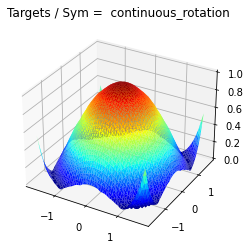

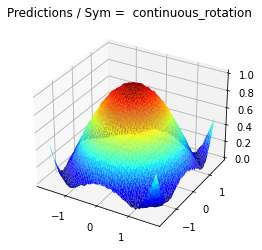


 ------ Without z ------ 



RMSE: 0.02547350712120533
Normalized RMSE: 2.547350712120533 %


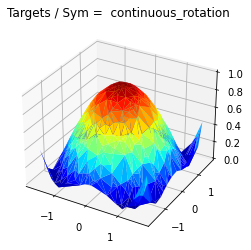

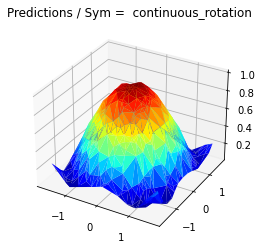


 ------ With z ------ 



RMSE: 0.011053592897951603
Normalized RMSE: 1.1053592897951603 %


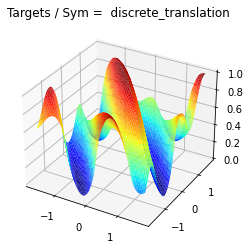

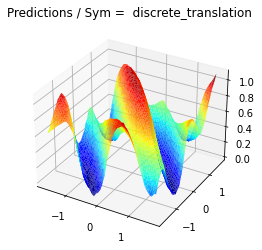


 ------ Without z ------ 



RMSE: 0.03119647316634655
Normalized RMSE: 3.130925370385281 %


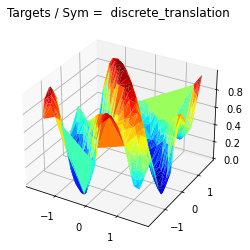

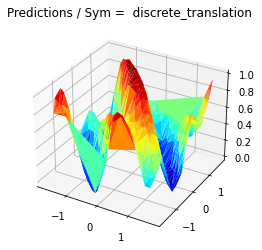


 ------ With z ------ 



RMSE: 0.026906805112957954
Normalized RMSE: 2.6906805112957954 %


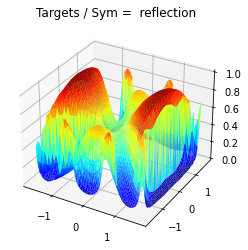

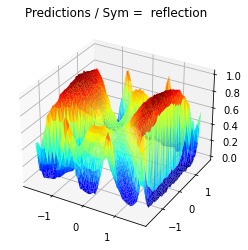


 ------ Without z ------ 



RMSE: 0.0634976252913475
Normalized RMSE: 6.351529743721705 %


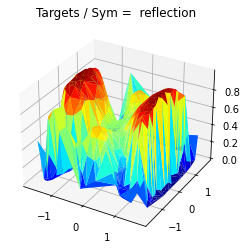

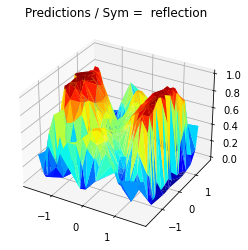


 ------ With z ------ 



RMSE: 0.020485861226916313
Normalized RMSE: 2.0485861226916313 %


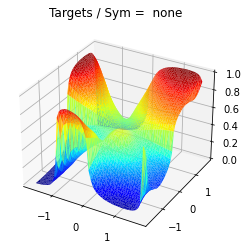

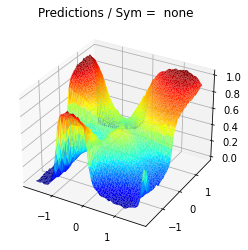


 ------ Without z ------ 



RMSE: 0.04424453154206276
Normalized RMSE: 4.443125588049687 %


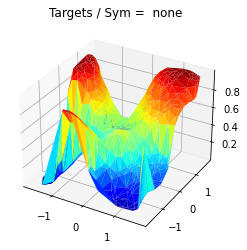

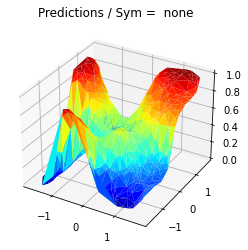


 ------ With z ------ 



RMSE: 0.007793325465172529
Normalized RMSE: 0.7793325465172529 %


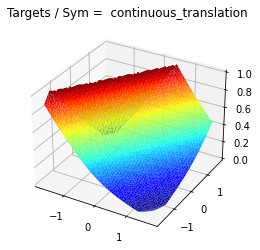

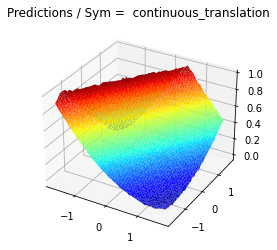


 ------ Without z ------ 



RMSE: 0.009398393332958221
Normalized RMSE: 0.9411577337419035 %


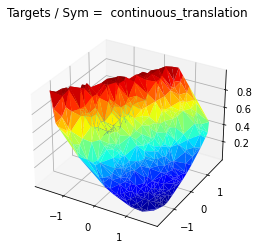

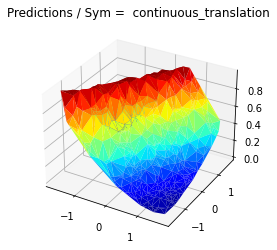

In [39]:
i = 0
for learn,to,tag in zip(models,to_s,PCA_s_tag):
  if i%2 == 0:
    print('\n ------ With z ------ \n')
  else:
    print('\n ------ Without z ------ \n')
  analisis(learn, to, tag, Graph = True)
  i += 1

## Análisis de la PCA usando la CNN entrenada

In [4]:
from fastai.vision.all import *
from time import time

In [11]:
dir2 = os.path.join(top_dir,'PCAs_todas')

In [12]:
pcas = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=Resize(224)
   ,batch_tfms=aug_transforms(mult=0.2,do_flip=False)
   )
 
path = Path(dir2)
 
dls = pcas.dataloaders(path,bs=64) #default 150

In [13]:
#Cargar:

model_name = 'model_90_accu_resnet18_one_cycle_10+5_no_mixup'
model_dir = top_dir + '/models/' + model_name

#model_name ='model_92_accu_resnet18_10+5_none+reflection'
#model_dir = top_dir + '/models/' + model_name

#learn2 = cnn_learner(dls, resnet50, metrics=accuracy, loss_func= LabelSmoothingCrossEntropy())
#learn2.load('/content/drive/MyDrive/model/model_97_accu_resnet50')

#learn2 = cnn_learner(dls, resnet34, metrics=accuracy)
#learn2.load('/content/drive/MyDrive/model/model1')

learn2 = cnn_learner(dls, resnet18, metrics=accuracy)
learn2.load(model_dir)


In [27]:
#learn2.export(model_dir+'.pkl') # Guardar modelo para hacer predicciones solo
#learn2=load_learner(model_dir+'.pkl',cpu=False) # Si solo es cargarlo para hacer predicciones

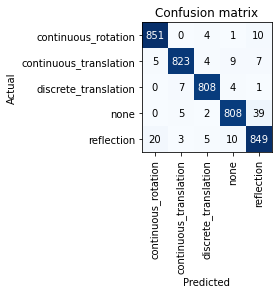

In [14]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

In [23]:
learn2.unfreeze()
learn2.fine_tune(freeze_epochs=1,epochs = 0, cbs = [SaveModelCallback(monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.176420,0.126469,0.968187,00:26


Better model found at epoch 0 with accuracy value: 0.968187153339386.


In [9]:
#Sacar la accuracy:
a = learn2.validate()
print('Accuracy:',a[1]*100,'%')

Accuracy: 91.6325330734253 %


In [51]:
test_im_dir = '/home/gabriel/Desktop/PCAs_5_layers_tests/none/z/z_none1630919181_PCA.png'

im = PILImage.create(test_im_dir)

-No funciona importar imagen con:

1. Librería pil: pil.Image.open()

2. Fastai Vision: from fastai.vision.all import Image
im = Image.open(test_im_dir) # Te pide que sea fastai.vision.core.PILImage

3. Hago un cast al tipo este
im = Image.open(test_im_dir)
im_t = cast(im, fastai.vision.core.PILImage) #No tiene atributo crop y no funciona

4. load_image() de fastai, que ya no existe al parecer

-Sí funciona con esto que también es de fastai

im = PILImage.create(test_im_dir)


In [52]:
learn2.predict(im)

('continuous_translation',
 tensor(1),
 tensor([1.9719e-07, 9.2285e-01, 1.8650e-08, 3.9805e-04, 7.6753e-02]))

# PCAS de las columnas x,y,z,bin

Para intentar encontrar la z, hacemos una PCA de las {columnas x, y, z, bin}, donde bin sustituye al valor del potencial. Mirando los coeficientes, deberíamos encontrar que nos separa bin & z por una parte, aunque x e y pueden aparecer mezcladas. 

In [53]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Un potencial

In [54]:
df_1 = potential_df(symmetry='none', with_z=True)
df_1 = df_1.drop('V',axis = 1)

In [55]:
df_1.head()

,x,y,z,bin
0,-1.0,-1.0,-1.000000,0.005803
1,-1.0,-1.0,-0.959184,0.005803
2,-1.0,-1.0,-0.918367,0.005803
3,-1.0,-1.0,-0.877551,0.005803
4,-1.0,-1.0,-0.836735,0.005803


### Escalando las variables

In [56]:
#rescale the data
X_scaled=StandardScaler().fit_transform(df_1)
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns=df_1.columns
#X.index=df.index
X_scaled.head()

,x,y,z,bin
0,-1.697749,-1.697749,-1.697749,-1.710575
1,-1.697749,-1.697749,-1.628453,-1.710575
2,-1.697749,-1.697749,-1.559158,-1.710575
3,-1.697749,-1.697749,-1.489862,-1.710575
4,-1.697749,-1.697749,-1.420566,-1.710575


In [57]:
pca=decomposition.PCA(n_components=4)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))
X_pca.columns = ['x','y','z','V']
X_pca.shape


loadings = pd.DataFrame(pca.components_)
loadings.index= ['PC1','PC2','PC3','PC4']
loadings.columns=X_pca.columns

In [58]:
loadings

,x,y,z,V
PC1,0.656327,-2.631243e-01,1.684547e-17,-7.071068e-01
PC2,-0.000000,3.794175e-17,-1.000000e+00,-3.794175e-17
PC3,-0.372114,-9.281870e-01,-3.521704e-17,-4.218847e-15
PC4,-0.656327,2.631243e-01,3.681226e-17,-7.071068e-01


<AxesSubplot:>

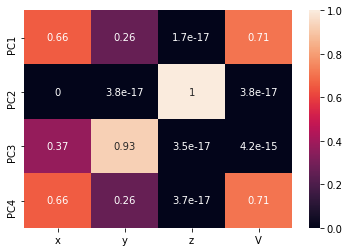

In [59]:
Index= ['x','y','z','V']
Cols = ['A', 'B', 'C', 'D']
df = pd.DataFrame(np.abs(loadings.to_numpy()), index=loadings.index, columns=X_pca.columns)

sns.heatmap(df, annot=True)

### Sin Escalar las variables

In [60]:
pca=decomposition.PCA(n_components=4)
X_pca = pd.DataFrame(pca.fit_transform(df_1))
X_pca.columns = ['x','y','z','V']
X_pca.shape


loadings = pd.DataFrame(pca.components_)
loadings.index= ['PC1','PC2','PC3','PC4']
loadings.columns=X_pca.columns

loadings

,x,y,z,V
PC1,0.908520,-3.642293e-01,3.141298e-16,-2.047654e-01
PC2,-0.000000,-8.294142e-16,-1.000000e+00,-5.876421e-17
PC3,-0.372114,-9.281870e-01,7.698515e-16,2.353673e-14
PC4,-0.190061,7.619608e-02,-5.679061e-18,-9.788111e-01


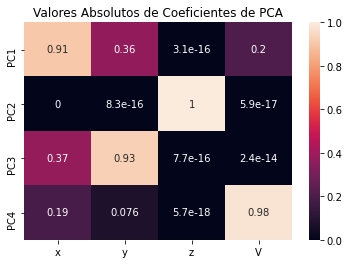

In [61]:
df = pd.DataFrame(np.abs(loadings.to_numpy()), index=loadings.index, columns=X_pca.columns)

hmp = sns.heatmap(df, annot=True).set(title='Valores Absolutos de Coeficientes de PCA')

In [65]:
coefs = loadings.to_numpy()
max_ind = np.where(np.abs(coefs) == np.amax(np.abs(coefs),axis = 0))
max_ind = max_ind[1]
columns = X_pca.columns
vals = []

for ind,i in zip(max_ind,range(4)):
    c = [k for k in range(4)]
    d = np.delete(c,np.where(c == ind))
    fila  = np.abs(coefs[i])
    nume = np.sum([fila[f] for f in d])/fila[ind]
    vals.append(nume)

vals = np.array(vals)
index = int(np.where(vals == np.amin(vals))[0])
index = max_ind[index]
print('Variable de mayor coeficiente en la PCA:',np.array(columns)[index])

Variable de mayor coeficiente en la PCA: z


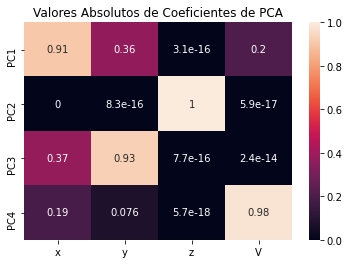

In [66]:
df = pd.DataFrame(np.abs(loadings.to_numpy()), index=loadings.index, columns=X_pca.columns)

hmp = sns.heatmap(df, annot=True).set(title='Valores Absolutos de Coeficientes de PCA')

## Prueba de Clasificación de variables irrelevantes con PCA (varios potenciales)

In [69]:
syms = ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']
#syms = ['continuous_rotation']
potenciales,tags = make_potentials(num_pot_cada = 1,with_z=True,symmetries = syms)

Todo Perfecto: Encontró la z en cada caso


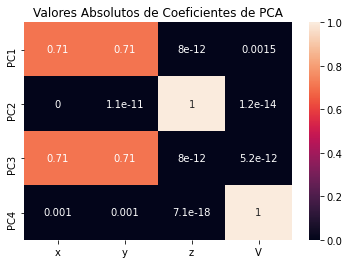

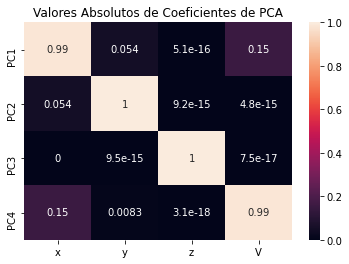

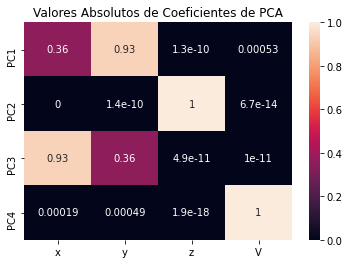

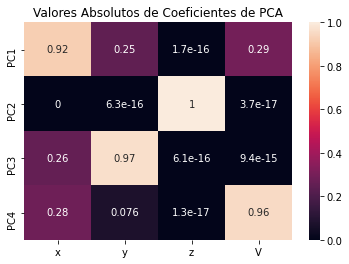

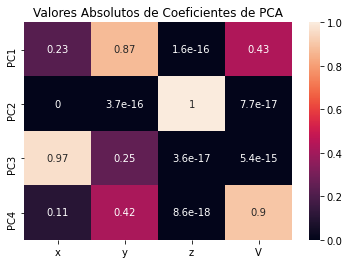

In [70]:
todo_bien = True
counts = [0,0,0,0]
#columnas = ['x','y','z+x','V']

for pot,tag in zip(potenciales,tags):
    
    pot = pot.drop('V',axis = 1)
    
    #pot.z = pot.x + pot.z
    #pot.y = pot.y + pot.z
    
    pca=decomposition.PCA(n_components=4)
    X_pca = pd.DataFrame(pca.fit_transform(pot))
    X_pca.columns = ['x','y','z','V']


    loadings = pd.DataFrame(pca.components_)
    loadings.index= ['PC1','PC2','PC3','PC4']
    loadings.columns=X_pca.columns

    
    coefs = loadings.to_numpy()
    vals = []
    max_ind = []

    for i in range(4):
        fila  = np.abs(coefs[i])
        ind = np.where(fila == np.amax(fila))
        max_ind.append(ind)
        c = [k for k in range(4)]
        d = np.delete(c,np.where(c == ind))
        
        nume = np.sum([fila[f] for f in d])/(fila[ind])
        #print(fila[ind],nume)
        vals.append(nume)

    vals = np.array(vals).flatten()
    index = int(np.where(vals == np.amin(vals))[0])
    
    index = max_ind[index]
    irrel = np.array(X_pca.columns)[index]
    if irrel[0] != 'z': 
        #print('Error encontrado al identificar z')
        todo_bien = False
    #print(tag,np.array(columns)[index])
    
    df = pd.DataFrame(np.abs(loadings.to_numpy()), index=loadings.index, columns=X_pca.columns)
    plt.figure()
    hmp = sns.heatmap(df, annot=True).set(title='Valores Absolutos de Coeficientes de PCA')
    
    men_cor = irrel[0]
    
    if men_cor == 'x':
        counts[0] += 1
    elif men_cor == 'y':
        counts[1] += 1
    elif men_cor == 'z':
        counts[2] += 1
    elif men_cor == 'V':
        counts[3] += 1

    
if todo_bien == True: print('Todo Perfecto: Encontró la z en cada caso')
#plt.bar(columnas,counts,color='darkviolet')

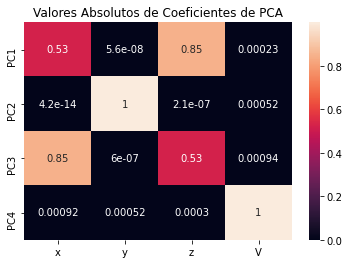

In [38]:
df = pd.DataFrame(np.abs(loadings.to_numpy()), index=loadings.index, columns=X_pca.columns)

hmp = sns.heatmap(df, annot=True).set(title='Valores Absolutos de Coeficientes de PCA')

In [210]:
loadings

,x,y,z,V
PC1,-8.506508e-01,-1.373300e-07,-5.257310e-01,0.000283
PC2,6.804762e-13,-9.999994e-01,8.259263e-07,0.001050
PC3,-5.257277e-01,4.031952e-06,8.506470e-01,0.003169
PC4,-1.906650e-03,-1.050476e-03,2.547456e-03,-0.999994


# Matriz de correlación

## Un Potencial

Menor correlación de V con x


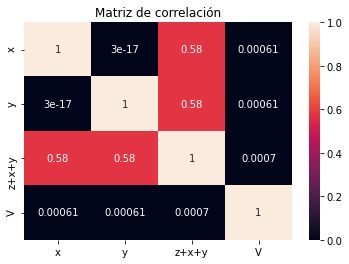

In [75]:
sym = 'continuous_rotation'

df_1 = potential_df(symmetry=sym, with_z=True)
df_1 = df_1.drop('V',axis = 1)

columnas = ['x','y','z+x+y','V']

df_test = df_1.copy()

df_test.z = df_test.x +  df_test.z + df_test.y

ll = df_test.corr()
df = pd.DataFrame(np.abs(ll.to_numpy()), index= columnas, columns=columnas)

aa = np.abs(np.array(ll.bin))
men_cor = ll.columns[np.where(aa == np.amin(aa))][0]
print('Menor correlación de V con', men_cor)

# heatmap de la matriz de correlacion: mejor si hay pocos potenciales
hmp = sns.heatmap(df, annot=True).set(title='Matriz de correlación')




## Muchos potenciales

Para ver si funciona lo de la matriz de correlación, probaremos cambiando z por x+y+z, y viendo en cada potencial la columna de menor correlación con el valor del mismo. Lo mejor sería si siempre fuera la que contiene la z, pero en la mayoría de casos no es así.

<BarContainer object of 4 artists>

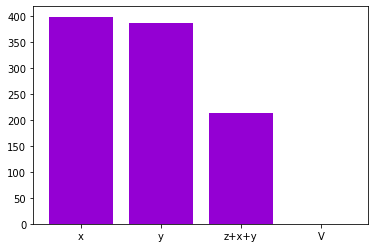

In [75]:
counts = [0,0,0,0]
printing = False
num_pot = 200 # Número de potenciales de cada simetría

for sym in ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']:
    for i in range(num_pot):   
        df_1 = potential_df(symmetry=sym, with_z=True)
        df_1 = df_1.drop('V',axis = 1)


        #columnas = ll.index
        columnas = ['x','y','z+x+y','V']


        df_test = df_1.copy()

        df_test.z = df_test.x +  df_test.z + df_test.y

        ll = df_test.corr()
        df = pd.DataFrame(np.abs(ll.to_numpy()), index= columnas, columns=columnas)

        # heatmap de la matriz de correlacion: mejor si hay pocos potenciales
        #hmp = sns.heatmap(df, annot=True).set(title='Matriz de correlación')


        aa = np.abs(np.array(ll.bin))
        men_cor = ll.columns[np.where(aa == np.amin(aa))][0]
        #print('Menor correlación:',men_cor)
        if men_cor == 'x':
            counts[0] += 1
        elif men_cor == 'y':
            counts[1] += 1
        elif men_cor == 'z':
            counts[2] += 1
        elif men_cor == 'V':
            counts[3] += 1

    if printing == True:
        print('Menor correlación:\n')
        print('x:',counts[0])
        print('y:',counts[1])
        print('z:',counts[2])
        print('V:',counts[3])

plt.bar(columnas,counts,color='darkviolet')

Text(0.5, 1.0, 'Columnas con menor correlación con V (1000 potenciales)')

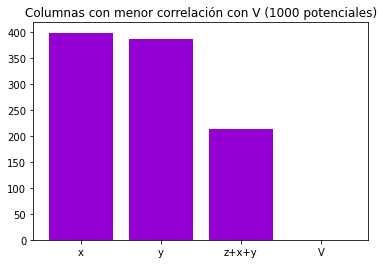

In [77]:
plt.bar(columnas,counts,color='darkviolet')
plt.title('Columnas con menor correlación con V (1000 potenciales)')

# Random Forest para encontrar columna con z (feature importance) 

## Un potencial, comparativa de los tres métodos

Accuracy trainig =  0.9101961048629142


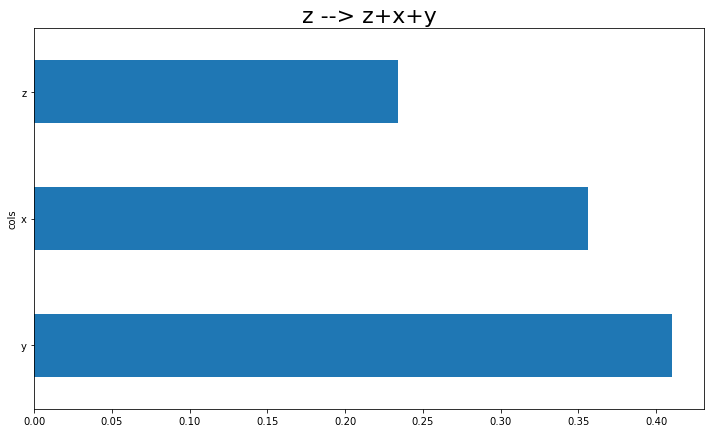

Menor correlación: x


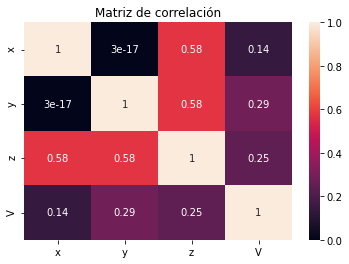

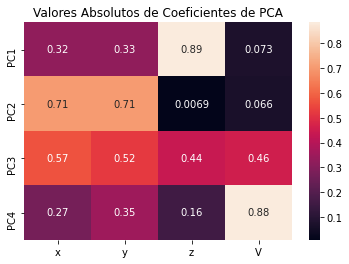

In [137]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.8, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


# Antes de nada, definimos la funcion accuracy para nuestro proyecto
def accu(pred,y):
  predo = pred 
  for i in range(len(pred)):
    if pred[i] < 0.5:
      predo[i] = 0
    else:
      predo[i] = 1
  
  accur = 1 - sum((y-predo)**2)/len(pred)
  
  return accur

def m_accu(m, xs, y): return accu(m.predict(xs), y)


# -------- Generar Potencial -----------#
df_1 = potential_df(symmetry='none', with_z=True)
df_1 = df_1.drop('V',axis = 1)

df_test = df_1.copy()

#--------- Editar algunas columnas ------#
df_test.z = df_test.x +  df_test.z + df_test.y

# ----- Separar en data + targets -------#
xs = df_test.drop('bin',axis = 1)
y = df_test.bin

# ----Modelo Random Forests ----#
m = rf(xs, y);
print('Accuracy trainig = ', accu(m.predict(xs),y))

# Feature Importance usando Random Forests
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)

fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plt.title('z --> z+x+y',fontsize = 22)
plt.show()


# ----- Comparación con Menor correlación ----- #
ll = df_test.corr()
columnas = ['x','y','z','V']
df = pd.DataFrame(np.abs(ll.to_numpy()), index= columnas, columns=columnas)
aa = np.abs(np.array(ll.bin))
men_cor = ll.columns[np.where(aa == np.amin(aa))][0]
print('Menor correlación:',men_cor)
plt.figure()
hmp = sns.heatmap(df, annot=True).set(title='Matriz de correlación')
plt.show()

# ------ Comparación con la PCA ----------------#
pca=decomposition.PCA(n_components=4)
X_pca = pd.DataFrame(pca.fit_transform(df_test))
X_pca.columns = ['x','y','z','V']
X_pca.shape


loadings = pd.DataFrame(pca.components_)
loadings.index= ['PC1','PC2','PC3','PC4']
loadings.columns=X_pca.columns

df = pd.DataFrame(np.abs(loadings.to_numpy()), index=loadings.index, columns=X_pca.columns)

plt.figure()
hmp = sns.heatmap(df, annot=True).set(title='Valores Absolutos de Coeficientes de PCA')
plt.show()


## Muchos potenciales, comparativa de los métodos

### Definiciones previas

In [163]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.8, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


# Antes de nada, definimos la funcion accuracy para nuestro proyecto
def accu(pred,y):
  predo = pred 
  for i in range(len(pred)):
    if pred[i] < 0.5:
      predo[i] = 0
    else:
      predo[i] = 1
  
  accur = 1 - sum((y-predo)**2)/len(pred)
  
  return accur

def m_accu(m, xs, y): return accu(m.predict(xs), y)

### Comparación de muchos potenciales 

In [160]:
counts = [0,0,0]
counts_cor = [0,0,0,0]
num_pot = 40 # Número de potenciales de cada simetría

print('Estudiando', num_pot*5, 'potenciales \n')

for sym in ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']:
    print('Symmetry = ', sym, '\n')
    for i in range(num_pot):   


        # -------- Generar Potencial -----------#
        df_1 = potential_df(symmetry=sym, with_z=True)
        df_1 = df_1.drop('V',axis = 1)

        df_test = df_1.copy()

        #--------- Editar algunas columnas ------#
        df_test.z = df_test.x +  df_test.z + df_test.y

        # ----- Separar en data + targets -------#
        xs = df_test.drop('bin',axis = 1)
        y = df_test.bin

        # ----Modelo Random Forests ----#
        m = rf(xs, y);
        #print('Accuracy trainig = ', accu(m.predict(xs),y))

        # Feature Importance usando Random Forests
        def rf_feat_importance(m, df):
            return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                               ).sort_values('imp', ascending=False)

        fi = rf_feat_importance(m, xs)
        
        # ----Plot Feature Importance ----#
        #fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
        #plt.title('z --> z+x+y',fontsize = 22)
        #plt.show()
        
        #Feature importance ordena las columnas por importancia, y la última es la que menos tiene
        men_cor = fi.cols.to_numpy()[-1]


        #print('Menor correlación:',men_cor)
        if men_cor == 'x':
            counts[0] += 1
        elif men_cor == 'y':
            counts[1] += 1
        elif men_cor == 'z':
            counts[2] += 1
            
            
        # ----- Comparación con Menor correlación ----- #
        ll = df_test.corr()
        columnas = ['x','y','z','V']
        aa = np.abs(np.array(ll.bin))
        men_cor = ll.columns[np.where(aa == np.amin(aa))][0]


        if men_cor == 'x':
            counts_cor[0] += 1
        elif men_cor == 'y':
            counts_cor[1] += 1
        elif men_cor == 'z':
            counts_cor[2] += 1
        elif men_cor == 'V':
            counts_cor[3] += 1

            
# Para comparar, quitamos el valor de V de las cuentas de correlación, porque V con V siempre tiene la máxima correlación         
basura = counts_cor.pop(-1)


Estudiando 200 potenciales 

Symmetry =  continuous_rotation 

Symmetry =  discrete_translation 

Symmetry =  reflection 

Symmetry =  none 

Symmetry =  continuous_translation 



### Gráficas:

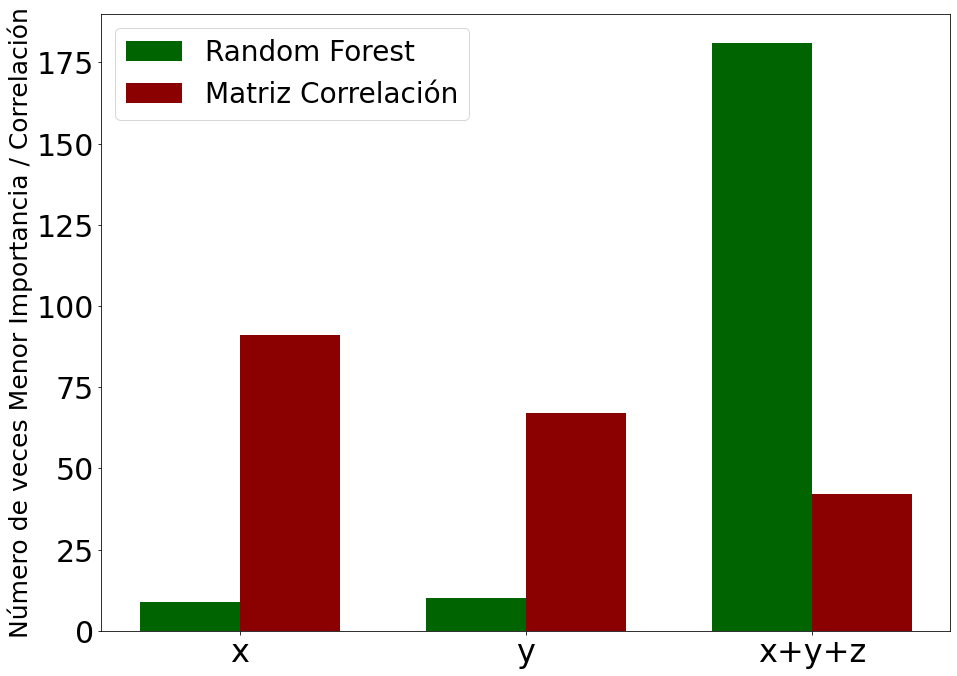

In [162]:
columnas = ['x','y','x+y+z']
c_rf = counts
c_cor = counts_cor

x = np.arange(len(columnas))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=[14,10])

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

rects1 = ax.bar(x - width/2, c_rf, width, label='Random Forest', color = 'darkgreen')
rects2 = ax.bar(x + width/2, c_cor, width, label='Matriz Correlación', color = 'darkred')


plt.ylabel('Número de veces Menor Importancia / Correlación', fontsize = 25)
plt.xticks(x, columnas, fontsize = 32)

fig.tight_layout()

plt.legend(fontsize = 28, loc = 'upper left')


### Función de feature importance solo pasando el dataframe

In [64]:
def fast_feat_imp_rf(df,target, graph = True):
    
    #Tiens un DataFrame con datos en columnas y un objetivo (target) que quieres predecir.
    #target es un string que tiene que ser el nombre de la columna objetivo
    
    def rf(xs, y, n_estimators=100, max_samples=300,
           max_features=0.8, min_samples_leaf=5, **kwargs):
        return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
            max_samples=max_samples, max_features=max_features,
            min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

    # ----- Separar en data + targets -------#
    xs = df.drop(target,axis = 1)
    y = df[[target]]

    # ----Modelo Random Forests ----#
    m = rf(xs, y);
    #print('Accuracy trainig = ', accu(m.predict(xs),y))

    # Feature Importance usando Random Forests
    def rf_feat_importance(m, df):
        return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                           ).sort_values('imp', ascending=False)

    fi = rf_feat_importance(m, xs)

    if graph == True:
        fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
        plt.title('Feature Importance. Target = '+target,fontsize = 22)
        plt.show()   
    
    return list(fi.cols)

## Por qué a veces no encuentra la z en 'continuous_translation' o 'discrete_translation'

Hay veces que califica de más relevante la variable x+y+z frente a solo x o solo y. Eso es algo natural: si la simetría es de translación contínua, y da la casualidad de que el potencial no cambia (o cambia poco) si nos movemos en x, la variable que tenga una 'y' tendrá mucha más relevancia para el valor del potencial. A continuación hay un ejemplo de esto.

In [133]:
def show_sample(n,funs):
  # Muestra imagenes (proyecciones) aleatorias contenidas en un vector de
  # dataframes de potenciales. Generas los potenciales previamente y los guardas todos en
  # en un array. Esta función te muestra una selección de ellos.
  # Necesita un numero de imagenes que mostrar y un array de dataframes que son
  # los potenciales generados.
  n = int(n)
  num_lado = int(np.ceil(np.sqrt(n)))
  fig = plt.subplots()
  j = 1
  for i in range(num_lado):
    for k in range(num_lado):
      if j <= n:
        axs = plt.subplot2grid((num_lado,num_lado), (i, k))
        img_array= np.array(pd.pivot_table(random.choice(funs),index='y',columns='x',values='bin', fill_value=0))
        plt.xlabel('x')
        plt.ylabel('y')
        axs.imshow(img_array)
        j = j+1
  return


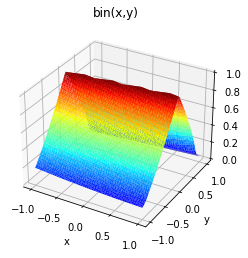

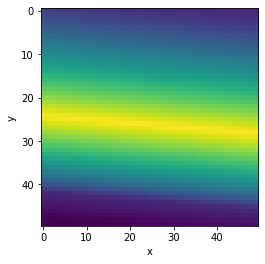

In [134]:
#df = potential_df('reflection')
df = df_test.copy()
ax2 = plt.axes(projection='3d')
ax2.plot_trisurf(df.x, df.y, df.bin, linewidth=0.2, cmap = 'jet')
plt.xlabel('x')
plt.ylabel('y')
plt.title('bin(x,y)')
plt.show()

show_sample(1,[df])

# Features with featurewiz

In [15]:
# !pip install featurewiz

In [21]:
from featurewiz import featurewiz

Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [66]:
# -------- Generar Potencial -----------#
df_1 = potential_df(symmetry='continuous_rotation', with_z=True)
df_1 = df_1.drop('V',axis = 1)

df_test = df_1.copy()

#--------- Editar algunas columnas ------#

'''
df_test['z_2'] = df_test.x
df_test['z_3'] = 2*df_test.z**2 
df_test['z_4'] = 2*df_test.z + df_test.y**2
df_test['z_5'] = 2*df_test.z**2 - df_test.x**2
df_test['x'] = df_test.z
'''

df_test.z = df_test.x +  df_test.z + df_test.y

#df_test.columns = ['x','y','z+x+y','bin']

df_test.head()

,x,y,z,bin
0,-1.0,-1.0,-3.000000,0.0
1,-1.0,-1.0,-2.959184,0.0
2,-1.0,-1.0,-2.918367,0.0
3,-1.0,-1.0,-2.877551,0.0
4,-1.0,-1.0,-2.836735,0.0


In [22]:
df_test.shape

## No Interaction / Comparación con RF

In [67]:
target = 'bin'

#Select 100k random elements without repetition
inds = random.sample(range(125000), 10000)
inds = np.sort(inds)
small_df = df_test.iloc[inds,:]

output = featurewiz(small_df, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (10000, 4)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    3 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
No GPU active on this device
    Running XGBoost using CPU parameters
Removing 0 columns from further processing since ID or low information variables
    columns removed: []
    After removing redundant variables from further processing, features left = 3
#### Single_Label Regression Feature Selection Started ####
Searching for highly correlated variables from 3 variables using SULOV method
#####  SULOV : Searching for Uncorrelated List Of Variables (takes time...) ############

In [71]:
fracn = fast_feat_imp_rf(df = df_test,target = 'bin', graph = False)


print('Most important features\nfeaturewiz:',output[0][:2])
print('Random Forest:',fracn[:2])

Most important features
featurewiz: ['y', 'x']
Random Forest: ['x', 'y']


## Interactions

Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (10000, 4)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    3 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
No GPU active on this device
    Running XGBoost using CPU parameters
Removing 0 columns from further processing since ID or low information variables
    columns removed: []
    After removing redundant variables from further processing, features left = 3
#### Single_Label Regression Feature Selection Started ####
Starting feature engineering...this will take time...
Source X_train shape:  (8000, 3) | X_test shape:  (2000, 3)
##################################################
> Start preprocessing with 3 variables
> Cleaned NaNs in nume

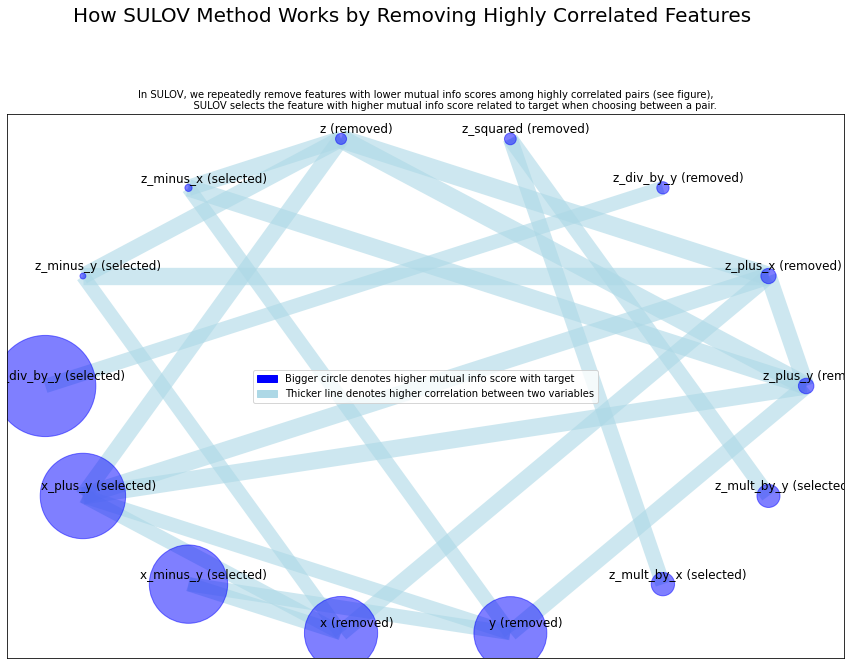

    Adding 0 categorical variables to reduced numeric variables  of 11
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 11 
    Finding Important Features using Boosted Trees algorithm...
        using 11 variables...
        using 9 variables...
        using 7 variables...
        using 5 variables...
        using 3 variables...
        using 1 variables...
Selected 11 important features from your dataset
    Time taken (in seconds) = 1
Returning list of 11 important features and dataframe.


In [81]:
target = 'bin'

#Select 100k random elements without repetition
inds = random.sample(range(125000), 10000)
inds = np.sort(inds)
small_df = df_test.iloc[inds,:]

output = featurewiz(small_df, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='interactions', category_encoders='')

Cuando hacemos esto de interactions, no nos podemos quedar con las dos features que más 'importancia' para featurewiz, que son las dos que pone primero, sino que tenemos que buscar, entre todo lo nuevo que ha generado, las dos variables más correlacionadas con el potencial. Sólo así coinciden los resultados de RF y FW. Random Forests dan en general un muy buen resultado a la hora de escoger las dos variables con las que nos queremos quedar.

In [113]:
def feat_imp_corr_fw(output):    
    
    best_feat = output[1]
    best_cols = best_feat.columns

    corr_bin = np.abs(best_feat.corr())['bin'].drop('bin')
    i_max_corr = np.where(corr_bin == np.max(corr_bin))[0][0]
    best_1 = best_cols[i_max_corr]

    corr_bin = corr_bin.drop(best_1)
    best_cols = best_cols.drop(best_1)

    i_max_corr = np.where(corr_bin == np.max(corr_bin))[0][0]
    best_2 = best_cols[i_max_corr]

    #print('Best correlation with V:',best_1, best_2)

    best_df = best_feat[[best_1,best_2,target]]
    
    return [best_1, best_2]

In [114]:
fracn = fast_feat_imp_rf(df = output[1],target = 'bin', graph = False)

sss = feat_imp_corr_fw(output)

print('Most important features\nfeaturewiz:',output[0][:2])
print('Random Forest:',fracn[:2])
print('featurewiz + correlation (bin + new vars):',sss)

Most important features
featurewiz: ['y_squared', 'x_mult_by_y']
Random Forest: ['x_squared', 'y_squared']
featurewiz + correlation (bin + new vars): ['x_squared', 'y_squared']


Con las features de featurewiz:

Better model found at epoch 0 with valid_loss value: 0.3731262981891632.


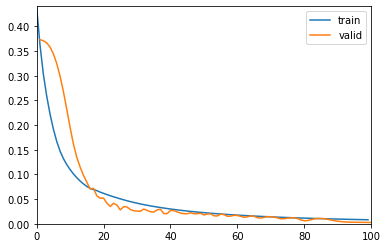

Better model found at epoch 1 with valid_loss value: 0.37128689885139465.
Better model found at epoch 2 with valid_loss value: 0.36683300137519836.
Better model found at epoch 3 with valid_loss value: 0.3584825098514557.
Better model found at epoch 4 with valid_loss value: 0.3448029160499573.
Better model found at epoch 5 with valid_loss value: 0.32540926337242126.
Better model found at epoch 6 with valid_loss value: 0.29966312646865845.
Better model found at epoch 7 with valid_loss value: 0.26846691966056824.
Better model found at epoch 8 with valid_loss value: 0.23303599655628204.
Better model found at epoch 9 with valid_loss value: 0.19571638107299805.
Better model found at epoch 10 with valid_loss value: 0.1618330329656601.
Better model found at epoch 11 with valid_loss value: 0.13508985936641693.
Better model found at epoch 12 with valid_loss value: 0.11507866531610489.
Better model found at epoch 13 with valid_loss value: 0.09837953746318817.
Better model found at epoch 14 with v

In [102]:
splits = RandomSplitter(valid_pct=0.2)(range_of(output[1]))

to = TabularPandas(output[1],
                procs=[Categorify,FillMissing],
                cont_names = output[0][:2],
                y_names = 'bin',
                splits=splits)



# Load the data into a DataLoader
dls = to.dataloaders(bs=5000)

# Define a Tabular Learner
learn = tabular_learner(dls, layers=[100,100,100,100,100,100]
                      #,config=config
                      ,metrics=[mse],
                      #y_range = [min(df.bin),max(df.bin)],
                      #,cbs=ShowGraphCallback()
                      #,train_bn=False)
                      )

#---------------- Entrenar red -----------------------------#


# Train the net 
with learn.no_logging():
      learn.fit_one_cycle(n_epoch=100
                          ,lr_max=0.01
                          ,cbs=[SaveModelCallback(),ShowGraphCallback()]
                          )

In [103]:
def analisis(learn, to, tag, Graph = True):
  preds, targs = learn.get_preds()
  
  #RMSE
  ff = (preds-targs)**2/len(targs)
  ff = sum(ff)
  RMSE = np.sqrt(ff)
  print('RMSE:',float(RMSE))
  print('Normalized RMSE:',float(RMSE)/(max(np.array(targs).flatten()-min(np.array(targs).flatten())))*100,'%')

  if Graph == True:
    # Targets
    plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(targs).flatten(), linewidth=0.2, cmap = 'jet')
    plt.title('Targets / Sym =  '+ tag)
    plt.show()

    #Predictions
    plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.plot_trisurf(np.array(to.valid['x']), np.array(to.valid['y']), np.array(preds).flatten(), linewidth=0.2, cmap = 'jet')
    plt.title('Predictions / Sym =  ' + tag)
    plt.show()

In [105]:
analisis(learn,to,'Potencial',Graph = False)

RMSE: 0.05234391242265701
Normalized RMSE: 5.234391242265701 %


Con las features de random forests:

Better model found at epoch 0 with valid_loss value: 0.4002733826637268.


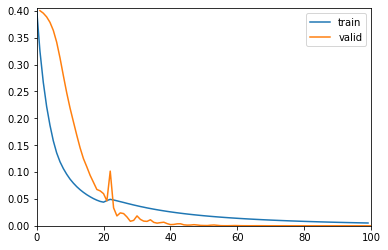

Better model found at epoch 1 with valid_loss value: 0.39566317200660706.
Better model found at epoch 2 with valid_loss value: 0.3887356221675873.
Better model found at epoch 3 with valid_loss value: 0.37859204411506653.
Better model found at epoch 4 with valid_loss value: 0.3635897934436798.
Better model found at epoch 5 with valid_loss value: 0.3416966199874878.
Better model found at epoch 6 with valid_loss value: 0.3123239278793335.
Better model found at epoch 7 with valid_loss value: 0.27941587567329407.
Better model found at epoch 8 with valid_loss value: 0.2475409060716629.
Better model found at epoch 9 with valid_loss value: 0.21896155178546906.
Better model found at epoch 10 with valid_loss value: 0.19368058443069458.
Better model found at epoch 11 with valid_loss value: 0.16868436336517334.
Better model found at epoch 12 with valid_loss value: 0.14499111473560333.
Better model found at epoch 13 with valid_loss value: 0.12492550909519196.
Better model found at epoch 14 with val

In [106]:
splits = RandomSplitter(valid_pct=0.2)(range_of(output[1]))

to = TabularPandas(output[1],
                procs=[Categorify,FillMissing],
                cont_names = fracn[:2],
                y_names = 'bin',
                splits=splits)



# Load the data into a DataLoader
dls = to.dataloaders(bs=5000)

# Define a Tabular Learner
learn = tabular_learner(dls, layers=[100,100,100,100,100,100]
                      #,config=config
                      ,metrics=[mse],
                      #y_range = [min(df.bin),max(df.bin)],
                      #,cbs=ShowGraphCallback()
                      #,train_bn=False)
                      )

#---------------- Entrenar red -----------------------------#


# Train the net 
with learn.no_logging():
      learn.fit_one_cycle(n_epoch=100
                          ,lr_max=0.01
                          ,cbs=[SaveModelCallback(),ShowGraphCallback()]
                          )

In [107]:
analisis(learn,to,'Potencial',Graph = False)

RMSE: 0.00668086763471365
Normalized RMSE: 0.668086763471365 %
